In [1]:
import sys
from threading import Thread
from multiprocessing.pool import ThreadPool
import numpy as np
import os
import matplotlib.pyplot as plt

from qiskit import transpile
from qclib.util import get_state
from qiskit.extensions import Initialize

from q_alchemy.qiskit import QAlchemyInitialize

sys.path.append('..')
os.environ["Q_ALCHEMY_API_KEY"] = "9X8AnHTs4EqSSH2lt3q01FovHY4inG7p"

In [2]:
def plot_digits(digits, labels, text, matrix_dim):
    _, axes = plt.subplots(nrows=1, ncols=len(digits), figsize=(20, 10))
    for ax, digit, label in zip(axes, digits, labels):
        ax.set_axis_off()
        image = digit[:int(matrix_dim**2)].reshape(matrix_dim, matrix_dim)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
        ax.set_title(label)

    plt.show()

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

C:\Users\cncen\AppData\Local\pypoetry\Cache\virtualenvs\q-alchemy-sdk-py-JllLCrix-py3.10\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


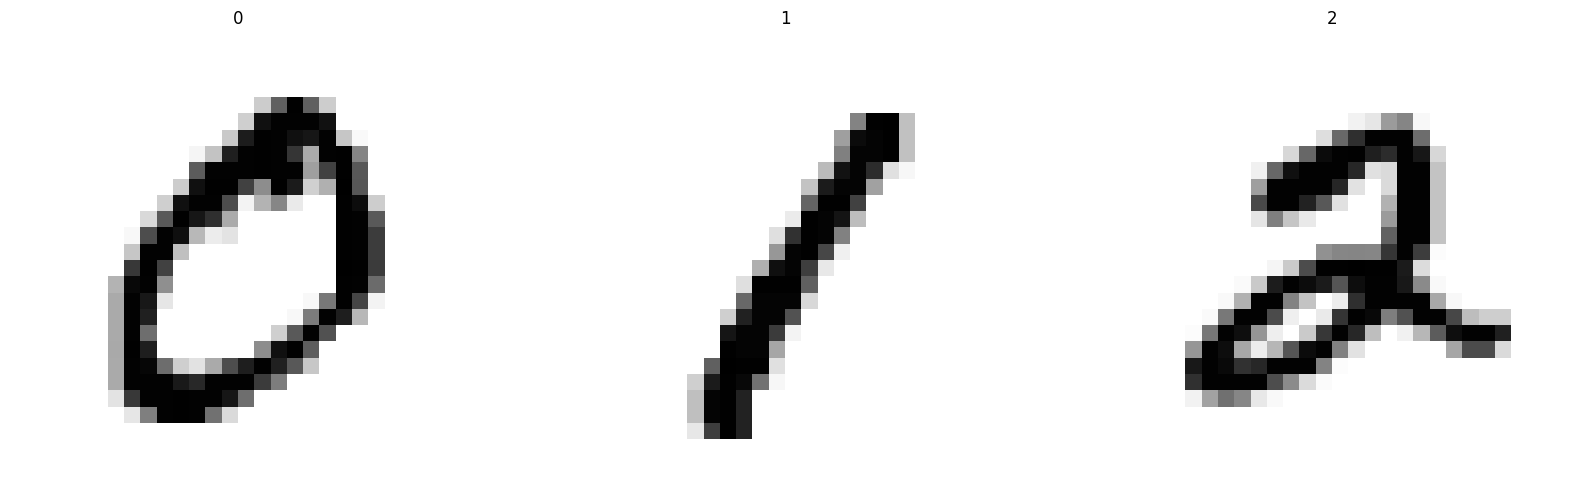

In [4]:
zero: np.ndarray = mnist.data[mnist.target == "0"].iloc[0].to_numpy()
one: np.ndarray = mnist.data[mnist.target == "1"].iloc[0].to_numpy()
two: np.ndarray = mnist.data[mnist.target == "2"].iloc[0].to_numpy()

filler = np.empty(2**10 - zero.shape[0])
filler.fill(0)

zero = np.hstack([zero, filler])
one = np.hstack([one, filler])
two = np.hstack([two, filler])

zero = zero / np.linalg.norm(zero)
one = one / np.linalg.norm(one)
two = two / np.linalg.norm(two)

plot_digits([zero, one, two], [0, 1, 2], "test", 28)

# Looking at the 0

In [5]:
def get_comparison_data(d: np.ndarray):
    
    qs_org = Initialize(d.tolist())
    qs_qc = transpile(qs_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    state = np.real(get_state(qs_org.definition)**2)
    cx_length = len(qs_qc.get_instructions("cx"))
    
    threads = []
    result = [
        [-1.0, cx_length, state]
    ]
    for fidelity_loss in np.linspace(0.0, 1.0, 11):
        def func(fl):
            sp_org = QAlchemyInitialize(d.tolist(), opt_params={'max_fidelity_loss': fl, "use_result_after_sec": None})
            qc = transpile(sp_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
            sp_length = len(qc.get_instructions("cx"))
            sp_state = np.real(get_state(sp_org.definition)**2)
            result.append([fl, sp_length, sp_state])
        job = Thread(target=func, args=(fidelity_loss,))
        job.start()
        threads.append(job)

    for x in threads: 
        x.join()
    
    return result

In [6]:
def plot_comparison(r):
    meta_data: np.ndarray = np.asarray([r[0:2] for r in r])
    sorting = meta_data[:, 0].argsort()
    meta_data = meta_data[sorting]
    
    image_data: np.ndarray = np.asarray([r[2] for r in r])
    image_data = image_data[sorting]
    
    labels = [f"{r[0]:.1f} @ {r[1]:n}cx" for r in meta_data]
    plot_digits(image_data, labels, "test", 28)

In [7]:
result_zero = get_comparison_data(zero)

In [8]:
result_one = get_comparison_data(one)

In [9]:
result_two = get_comparison_data(two)

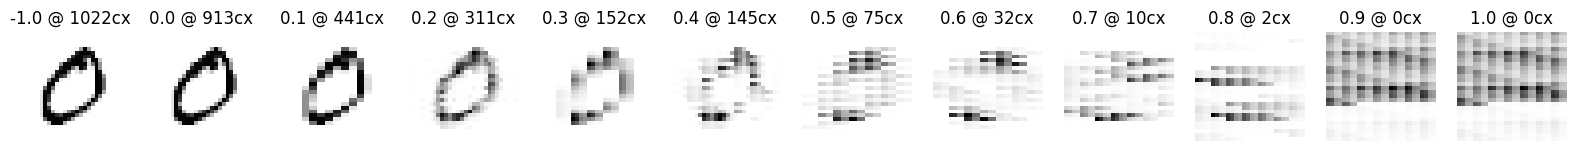

In [10]:
plot_comparison(result_zero)

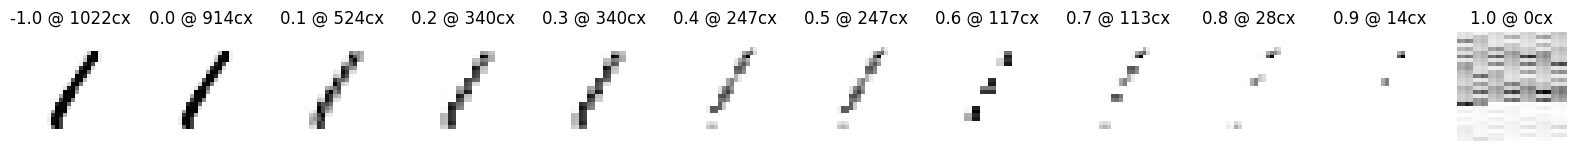

In [11]:
plot_comparison(result_one)

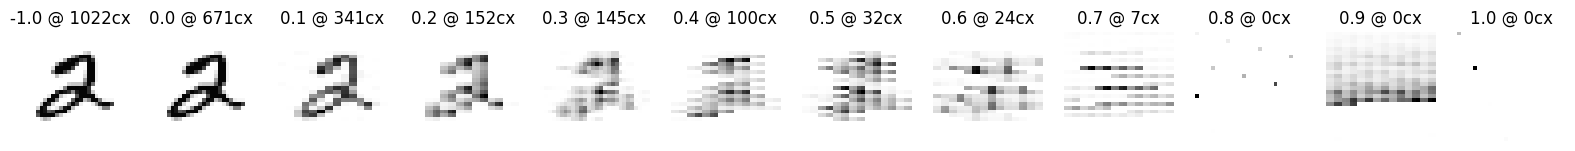

In [12]:
plot_comparison(result_two)